In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import pandas as pd
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report#, confusionMatrix
from sklearn.feature_selection import SelectKBest, chi2
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import warnings
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("combined_df.csv")
data.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,...,dir_flop,actor_total,actor_blockbuster,actor_success,actor_flop,dir_act_total,dir_act_blockbuster,dir_act_success,dir_act_flop,dataset
0,42816,The Champ,7.023,43,Released,11/21/1931,1600000,86,False,356000,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,test
1,15467,Kismat Konnection,4.972,53,Released,7/18/2008,11000000,153,False,4180000,...,NaN,8.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,test
2,623010,Timecrowave,0.000,0,Released,5/9/2018,1000,13,False,500,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,test
3,258832,Convention City,1.000,1,Released,12/14/1933,522000,69,False,239000,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
4,45272,Country Strong,6.195,230,Released,12/22/2010,20601987,117,False,15000000,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test


In [4]:
data.shape

(11686, 97)

In [5]:
# max_popularity = data['popularity'].max()
# max_popularity

In [6]:
#data['popularity_pct'] = (data['popularity']*100)/max_popularity

In [7]:
# columns_to_display = ['popularity', 'popularity_pct']  # Specify the columns you want to display
# data[columns_to_display].head()
# data['popularity_pct'].min()

In [8]:
#data['avg_rating'] = (data['vote_average']+ (data['popularity_pct']/10))/2
#data.head()
data["actor1Name"]=data["actor1Name"].astype("category")
data["dir1Name"]=data["dir1Name"].astype("category")


In [9]:
# # List of text columns to keep
# columns_to_keep = ['actor1Name','dir1Name','success_level','dataset']

# # Identify all columns with text (object) data type
# text_columns = data.select_dtypes(include=['object']).columns

# # Drop text columns except the ones in the keep list
# columns_to_drop = [col for col in text_columns if col not in columns_to_keep]
# train_filtered = data.drop(columns=columns_to_drop)

# categorical_cols = data.select_dtypes(include=['object']).columns

# label_encoder = LabelEncoder()

# # Apply LabelEncoder to each categorical column
# for col in categorical_cols:
#     data[col] = label_encoder.fit_transform(data[col])


In [10]:
#split the data into into train and test
train_data = data[data['dataset'] == 'train']
validate_data = data[data['dataset'] == 'validation']
test_data = data[data['dataset'] == 'test']

In [11]:
#check for the data distribution for train distribution
train_data['success_level'].value_counts()

success_level
Success        3177
Flop           3074
Blockbuster    1929
Name: count, dtype: int64

In [12]:
#train_data.shape

In [13]:
#validate_data.shape

In [27]:
#test_data.shape

In [28]:
#data[data['dataset'].isnull()]

In [31]:
#train_data.dtypes

In [33]:
#Drop all text fields except for actorname and dirname and our Y 

# List of text columns to keep
columns_to_keep = ['actor1Name','dir1Name','success_level']

# Identify all columns with text (object) data type
text_columns = train_data.select_dtypes(include=['object']).columns

# Drop text columns except the ones in the keep list
columns_to_drop = [col for col in text_columns if col not in columns_to_keep]
train_filtered = train_data.drop(columns=columns_to_drop)


In [35]:
# train_data.shape
# train_filtered.shape

In [37]:
#Seperate the X and Y and convert Y to numeric and remove unwanted numeric fields in X
X_noy =  train_filtered.drop('success_level', axis=1)
#X_without_text_columns = X_noy.select_dtypes(exclude=['object'])
Y = train_data[['success_level']]
#X_without_text_columns.head()
X = X_noy.drop(['id','revenue','popularity','budget_millions','revenue_millions','ordering_x','ordering_y','roi','vote_average',	'vote_count','popularity','revenue','profit'], axis=1)
#X_train = X.fillna(X.mean())
#[X.select_dtypes(include=['number']).columns] = X.select_dtypes(include=['number']).fillna(X.mean())
# Select numeric columns only
#numeric_cols = X.select_dtypes(include=['number']).columns

# Fill missing values in numeric columns with the mean of each column
#X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())
X.head()
label_encoder = LabelEncoder()
Y_numeric = label_encoder.fit_transform(Y)

In [39]:
#X.shape
#Y_numeric.shape

In [41]:
#Convert actroName and Dirname to categorical for the model to be able to use it as XGBoost can handle text only as categories
X["actor1Name"]=X["actor1Name"].astype("category")
X["dir1Name"]=X["dir1Name"].astype("category")

In [43]:
# def stepwise_selection(X_train, y_train, threshold_in=0.05, threshold_out=0.05):
#     """
#     Perform stepwise regression: Both forward and backward selection.
    
#     X_train : Training dataset with the intercept
#     y_train : Target variable
#     threshold_in : Entry p-value threshold for a feature to enter the model
#     threshold_out : Exit p-value threshold for a feature to be removed
#     """
#     initial_features = X_train.columns.tolist()
#     included = list(initial_features)
#     while True:
#         changed = False
#         # Forward step: Add features that improve the model
#         excluded = list(set(initial_features) - set(included))
#         new_pval = pd.Series(index=excluded)
#         for new_col in excluded:
#             model = sm.Logit(y_train, X_train[included + [new_col]]).fit(disp=False)
#             new_pval[new_col] = model.pvalues[new_col]
#         min_pval = new_pval.min()
#         if min_pval < threshold_in:
#             best_feature = new_pval.idxmin()
#             included.append(best_feature)
#             changed = True

#         # Backward step: Remove features that have a high p-value
#         model = sm.Logit(y_train, X_train[included]).fit(disp=False)
#         pvalues = model.pvalues[1:]  # exclude intercept
#         max_pval = pvalues.max()
#         if max_pval > threshold_out:
#             worst_feature = pvalues.idxmax()
#             included.remove(worst_feature)
#             changed = True
        
#         if not changed:
#             break
#     return included

In [45]:
# from sklearn.preprocessing import OrdinalEncoder
# #import numpy as np
# categorical_cols = X.select_dtypes(include=['object']).columns

# # Apply Ordinal Encoding
# encoder = OrdinalEncoder()
# X[categorical_cols] = encoder.fit_transform(X[categorical_cols])


In [47]:
#X = X.drop(['vote_average', 'vote_count','popularity', 'profit','popularity_pct', 'avg_rating','roi'], axis=1)

In [49]:
# label_encoder = LabelEncoder()
# Y_numeric = label_encoder.fit_transform(Y)
# xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False,enable_categorical=True, random_state=42)
# sfs = SequentialFeatureSelector(xgb,
#                                 k_features=10,
#                                 forward=True,
#                                 scoring='accuracy',
#                                # max_iter=100,
#                                 cv=5)
# selected_features = sfs.fit(X, Y_numeric)
# print(selected_features.k_feature_names_)

In [51]:
#print(selected_features.k_feature_names_)

In [53]:
#X.columns

In [55]:
#Train the model on XGB classifier we spcify num class as 3 as we have 3 categories for our Y and 
categorical_cols = X.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False,enable_categorical=True, random_state=42)
xgb.fit(X, Y_numeric)
# Must use JSON/UBJSON for serialization, otherwise the information is lost.
y_train_pred = xgb.predict(X)
xgb.save_model("XGBoost-model.json")
xgb.feature_importances_

array([0.00164486, 0.00126296, 0.00172729, 0.00226197, 0.0024517 ,
       0.00136543, 0.00172085, 0.00167415, 0.00149738, 0.00152874,
       0.00251947, 0.00252015, 0.00173636, 0.00206273, 0.00196841,
       0.00187389, 0.00180889, 0.00217277, 0.00062519, 0.00119164,
       0.00203502, 0.00137417, 0.00216192, 0.00249955, 0.00092146,
       0.00065175, 0.00231394, 0.00166243, 0.        , 0.00117866,
       0.00127208, 0.00084274, 0.00156574, 0.00072738, 0.0019949 ,
       0.001044  , 0.00134303, 0.00182825, 0.00126743, 0.00185379,
       0.00174628, 0.0012206 , 0.0013647 , 0.00187329, 0.00224176,
       0.00163204, 0.00391104, 0.00368388, 0.01680788, 0.00087619,
       0.00075382, 0.00115908, 0.01422863, 0.00185546, 0.00192351,
       0.00115378, 0.06611896, 0.29595467, 0.23913267, 0.2782086 ],
      dtype=float32)

In [56]:
#cross validation of the dataset 
cv_scores = cross_val_score(xgb, X, Y_numeric, cv=5, scoring='accuracy')

# Print the cross-validation scores
print(f'Cross-validation scores: {cv_scores}')

# Print the mean and standard deviation of the cross-validation scores
print(f'Mean CV score: {np.mean(cv_scores)}')
print(f'Standard deviation of CV scores: {np.std(cv_scores)}')

Cross-validation scores: [0.90953545 0.91136919 0.91381418 0.91198044 0.9205379 ]
Mean CV score: 0.9134474327628362
Standard deviation of CV scores: 0.0037995770826210655


In [59]:
#accuracy on train set 
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train_pred, Y_numeric)

print(f"Training accuracy: {train_accuracy * 100:.2f}%")

Training accuracy: 99.36%


In [61]:
#for validation set remove the text fields as in train data except actor director names 

# List of text columns to keep
columns_to_keep = ['actor1Name','dir1Name','success_level']

# Identify all columns with text (object) data type
text_columns = validate_data.select_dtypes(include=['object']).columns

# Drop text columns except the ones in the keep list
columns_to_drop = [col for col in text_columns if col not in columns_to_keep]
validate_filtered = validate_data.drop(columns=columns_to_drop)


In [65]:
#validation set perform the data processing as done on training set 
X_val_noy =  validate_filtered.drop('success_level', axis=1)
#X_without_text_columns = X_noy.select_dtypes(exclude=['object'])
Y_val = validate_data[['success_level']]
#X_without_text_columns.head()
X_val = X_val_noy.drop(['id','revenue','budget_millions','revenue_millions','ordering_x','ordering_y','roi','vote_average',	'vote_count','popularity','revenue','profit'], axis=1)
#X_train = X.fillna(X.mean())
#[X.select_dtypes(include=['number']).columns] = X.select_dtypes(include=['number']).fillna(X.mean())
# Select numeric columns only
#numeric_cols = X_val.select_dtypes(include=['number']).columns

# Fill missing values in numeric columns with the mean of each column
#X_val[numeric_cols] = X_val[numeric_cols].fillna(X_val[numeric_cols].mean())
X_val.head()
X_val["actor1Name"]=X_val["actor1Name"].astype("category")
X_val["dir1Name"]=X_val["dir1Name"].astype("category")

In [67]:

categorical_cols = X_val.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    X_val[col] = label_encoder.fit_transform(X_val[col])
#label_encoder = LabelEncoder()
Y_val_numeric = label_encoder.fit_transform(Y_val)
#xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False,enable_categorical=True, random_state=42)
#xgb.fit(X, Y_numeric)
# Must use JSON/UBJSON for serialization, otherwise the information is lost.
#y_train_pred = xgb.predict(X)
#xgb.save_model("XGBoost-model.json")
#xgb.feature_importances_

In [275]:
#X_val.shape

(1752, 60)

In [74]:
#we have used Grid Search CV for hyper tuning the paramters but because of the complexity and num of paramters at times grid search took really long
# and to get around with this we have used RandomizedSearchCV at times 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # eta
    'n_estimators': [50, 100, 200, 300],      # Number of boosting rounds
    'max_depth': [3, 6, 9],                    # Maximum depth of each tree
    'min_child_weight': [1, 3, 5],              # Minimum sum of instance weight in a child
    'subsample': [0.6, 0.8, 1.0],              # Fraction of samples for fitting each tree
    'colsample_bytree': [0.6, 0.8, 1.0],       # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.2],                   # Minimum loss reduction required to make further partitions
    'scale_pos_weight': [1, 2, 5]              # Adjusts weights for imbalanced datasets
}

# Set up GridSearchCV
#grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
#Randomeized serch CV
grid_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_val, Y_val_numeric)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best score
print("Best accuracy found: ", grid_search.best_score_)

# Evaluate on the test set (optional)
#best_model = grid_search.best_estimator_
#y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Best accuracy found:  0.5091324200913242


In [75]:
best_model = grid_search.best_estimator_
#y_pred = best_model.predict(X_test)

In [76]:

#for the test data work on formatting data and removing unwanted data 
# List of text columns to keep
columns_to_keep = ['actor1Name','dir1Name','success_level']

# Identify all columns with text (object) data type
text_columns = test_data.select_dtypes(include=['object']).columns

# Drop text columns except the ones in the keep list
columns_to_drop = [col for col in text_columns if col not in columns_to_keep]
test_filtered = test_data.drop(columns=columns_to_drop)

In [77]:
X_test_noy =  test_filtered.drop('success_level', axis=1)
#X_without_text_columns = X_noy.select_dtypes(exclude=['object'])
Y_test = test_data[['success_level']]
Y_test_numeric = label_encoder.fit_transform(Y_test)
#X_without_text_columns.head()
X_test = X_test_noy.drop(['id','revenue','budget_millions','revenue_millions','ordering_x','ordering_y','roi','vote_average',	'vote_count','popularity','revenue','profit'], axis=1)
#X_train = X.fillna(X.mean())
#[X.select_dtypes(include=['number']).columns] = X.select_dtypes(include=['number']).fillna(X.mean())
# Select numeric columns only
#numeric_cols = X_test.select_dtypes(include=['number']).columns

# Fill missing values in numeric columns with the mean of each column
#X_test[numeric_cols] = X_test[numeric_cols].fillna(X_test[numeric_cols].mean())
X_test.head()
X_test["actor1Name"]=X_test["actor1Name"].astype("category")
X_test["dir1Name"]=X_test["dir1Name"].astype("category")

In [78]:
#X_test.shape
#Y_test_numeric.shape

In [79]:
categorical_cols = X_test.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    X_test[col] = label_encoder.fit_transform(X_test[col])

#xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False,enable_categorical=True, random_state=42)
#xgb.fit(X, Y_numeric)
# Must use JSON/UBJSON for serialization, otherwise the information is lost.
#y_train_pred = xgb.predict(X)
#xgb.save_model("XGBoost-model.json")
#xgb.feature_importances_

In [80]:
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test_pred, Y_test_numeric)

print(f"test accuracy: {test_accuracy * 100:.2f}%")

test accuracy: 53.57%


In [81]:
confusion_matrix(y_test_pred, Y_test_numeric)

array([[110,  25,  51],
       [127, 427, 228],
       [171, 212, 402]], dtype=int64)

In [82]:
from sklearn.metrics import f1_score
f1_per_class = f1_score(y_test_pred, Y_test_numeric, average=None)
print("F1 Score per class:", f1_per_class)

F1 Score per class: [0.37037037 0.59059474 0.54843111]


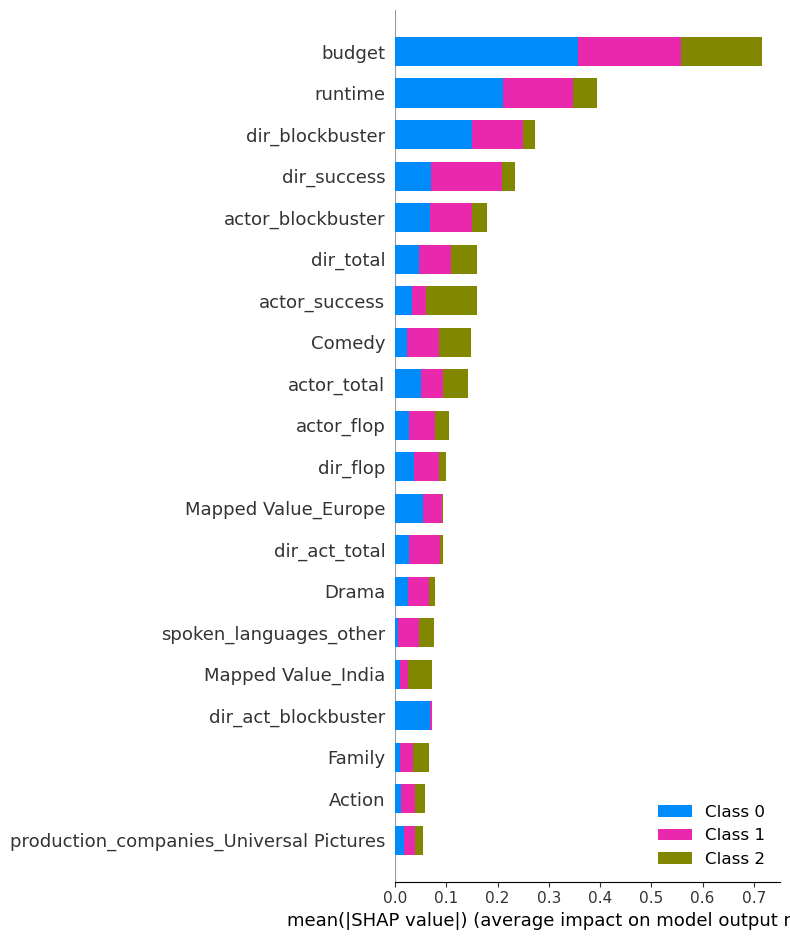

In [295]:
#!pip install shap
#get the feature importance
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)  # Use test data
shap.summary_plot(shap_values, X_test)

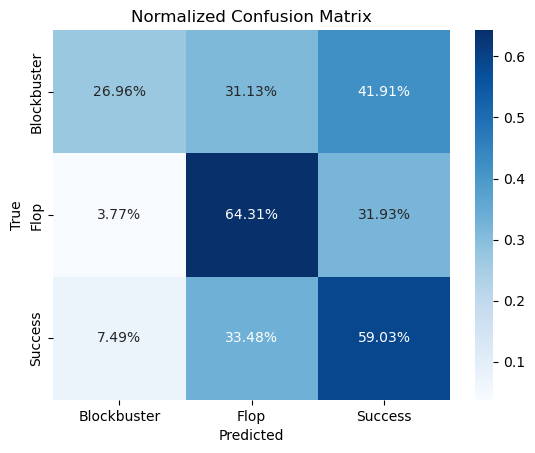

In [92]:
#get comfusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test_numeric, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Blockbuster', 'Flop', 'Success'], yticklabels=['Blockbuster', 'Flop', 'Success'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [299]:
#getting label encoding for Y 
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
encoder = LabelEncoder()

# Fit the encoder on Y_test (or whatever labels you have)
encoder.fit(Y_test)

# Now you can access encoder.classes_
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(label_mapping)

{'Blockbuster': 0, 'Flop': 1, 'Success': 2}


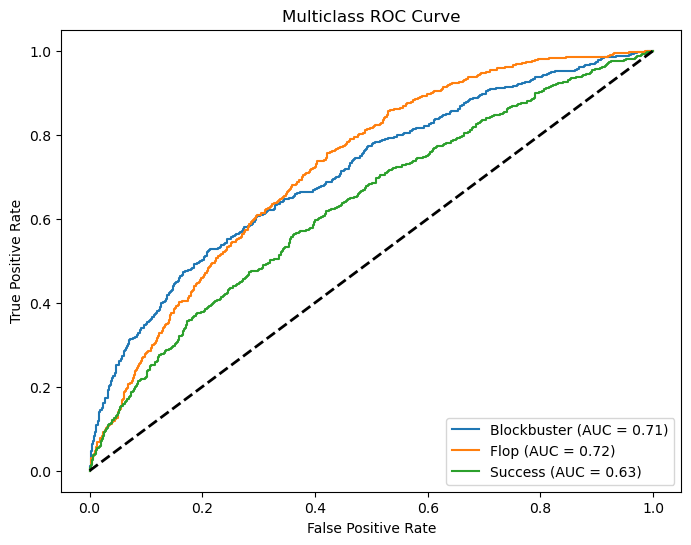

In [301]:
#Get the ROC curve 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming Y_test_numeric are the true labels in numeric form (e.g., 0, 1, 2 for 3 classes)
# and best_model is your trained model

# Define a mapping from numeric class labels to class names
class_names = {0: 'Blockbuster', 1: 'Flop', 2: 'Success'}

n_classes = len(set(Y_test_numeric))  # Number of classes
y_test_bin = label_binarize(Y_test_numeric, classes=range(n_classes))  # Binarize the true labels
y_probs = best_model.predict_proba(X_test)  # Get predicted probabilities for each class

# Create a figure for the ROC curve plot
plt.figure(figsize=(8, 6))

# Loop through each class to plot the ROC curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])  # Compute ROC curve for each class
    roc_auc = auc(fpr, tpr)  # Compute the AUC for each class
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')  # Plot the ROC curve with class name

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')  # Display the legend
plt.show()


In [305]:
#get F1 Score 
from sklearn.metrics import f1_score
f1_per_class = f1_score(Y_test_numeric, y_test_pred, average=None)
print("F1 Score per class:", f1_per_class)

#from sklearn.metrics import f1_score

f1_micro = f1_score(Y_test_numeric, y_test_pred, average='micro')
print("Micro F1 Score:", f1_micro)

F1 Score per class: [0.3982684  0.56813266 0.50771388]
Micro F1 Score: 0.5099828864803194
